# Introduction
It is important for businesses to know how to market their products to the right people, in the right place, at the right time, and using data about the customer and their order we can do this more effectively.

We are given a dataset that includes orders with customer details, and whether or not the product was returned. The goal of this notebook is to predict the probability that a future item that is ordered will result in being returned.

# Exploratory Data Analysis

In [2]:
#Relative imports of packages and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
train = pd.read_csv("Downloads/Transactions/Transactions/train.csv")
test = pd.read_csv("Downloads/Transactions/Transactions/test.csv")

#Lets look at the data
train.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned
0,58334388-e72d-40d3-afcf-59561c262e86,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Youth,M,9,0.0356,28.93,0
1,fb73c186-ca70-4eea-b80e-422d732205aa,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1192,44.92,0
2,7590dca6-7344-4a11-ad6e-bd9100730c33,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,XL,20,0.1698,48.98,0
3,cb8cf8da-ef31-4b6f-b515-3a7f75d17d0f,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1973,51.37,0
4,b7d5f19d-ebf0-48c1-afb2-4f066cb5f04e,ce1867af-0846-4352-bdda-465e88c2c2ed,19c8c37f-d1ab-488e-848c-c28ba9c5d80c,Indiana,1979-01-11,2016-01-11,Womens,XS,42,0.0663,113.91,0


Our goal is to see what gets returned. Let's look at general stats about returns and how they relate to the other variables.

In [3]:
#Total rate of items in the dataset that have been returned
returns = train['Returned'].sum()
display(returns/len(train.index))

0.35243098348533397

### For the data we have - About 35% of the items that are ordered get returned.

<AxesSubplot:xlabel='bin', ylabel='NumReturns'>

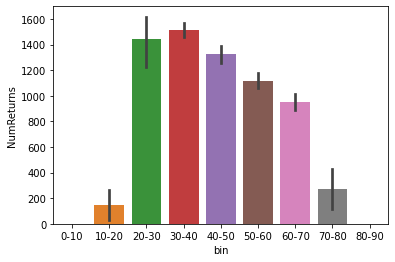

In [7]:
#Add age as a variable
train['OrderDate']= pd.to_datetime(train['OrderDate'])
train['CustomerBirthDate']= pd.to_datetime(train['CustomerBirthDate'])
train['Age'] = train['OrderDate'] - train['CustomerBirthDate']
train['Age'] = train['Age'] / np.timedelta64(1, 'Y')
train['Age'] = train['Age'].astype('int')

#Visualize ages and the amount they return by group
age_counts = train["Age"].value_counts()
age_counts = age_counts.to_frame().reset_index()
age_counts = age_counts.rename(columns={"Age": "NumReturns", 'index': 'Age'})

age_counts['bin'] = pd.cut(age_counts['Age'], bins=range(0,91,10), labels=[f'{l}-{l+10}' for l in range(0,81,10)])
age_counts.head()
sns.barplot(x='bin', y='NumReturns', data=age_counts)

Let's look at returns by state as well.

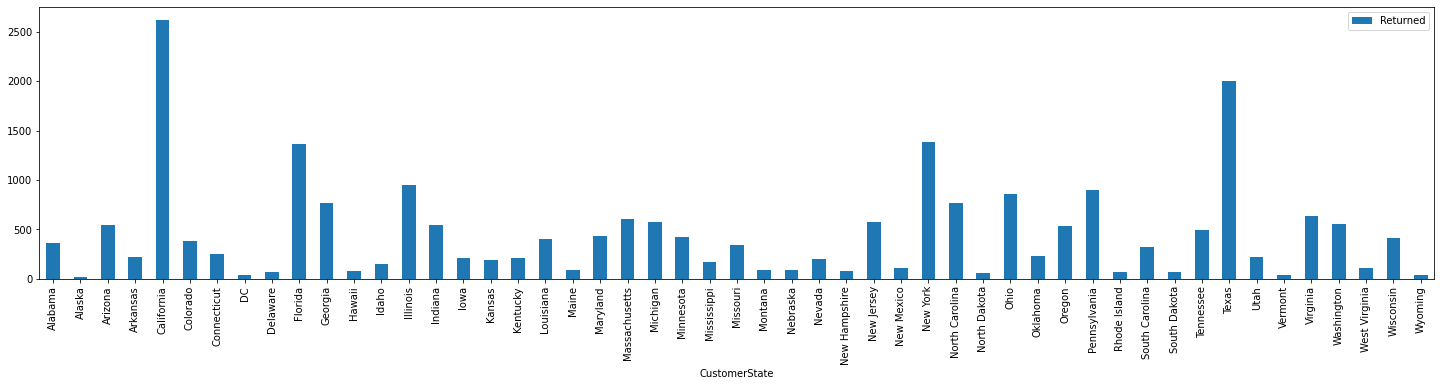

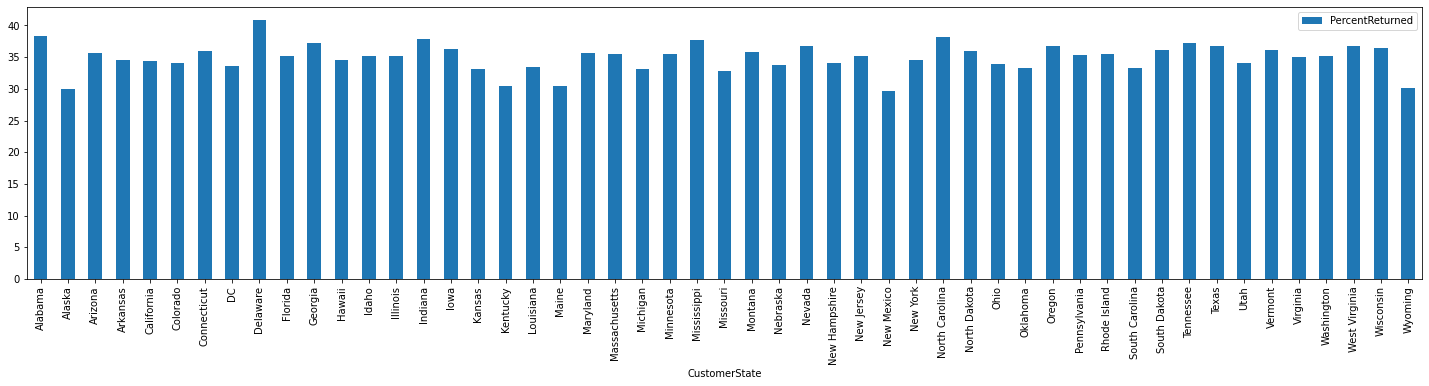

In [10]:
df = train.groupby('CustomerState').sum().reset_index()

totals = train['CustomerState'].value_counts()
totals = totals.to_frame()
totals = totals.reset_index()

totals = totals.rename(columns={"CustomerState": "Total", 'index': 'CustomerState'})
totals = totals.sort_values('CustomerState')
totals = totals.reset_index()


df['PercentReturned'] = df['Returned']/totals['Total'] * 100

#Visualize the data compared to other states
df.plot(kind = 'bar', x = 'CustomerState', y = 'Returned')
df.plot(kind = 'bar', x = 'CustomerState', y = 'PercentReturned')
plt.rcParams['figure.figsize'] = [15, 5]

There doesn't seem to be much difference state to state on how much people return items. Maybe less so in Alaska because of location.

<AxesSubplot:xlabel='ProductDepartment'>

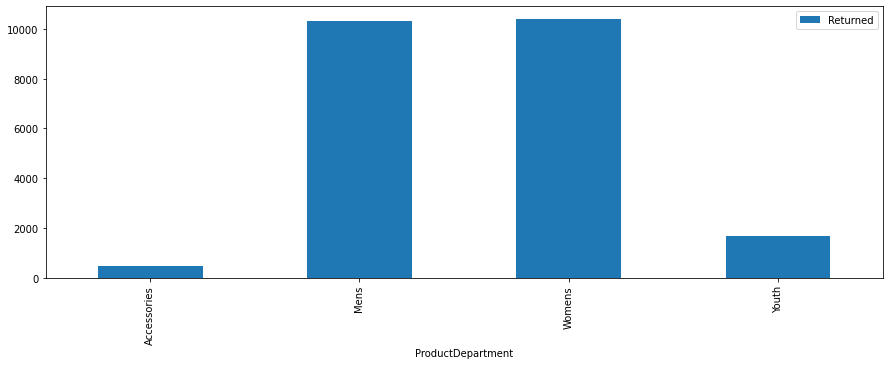

In [11]:
#Lets look at returns by product department

df1 = train.groupby('ProductDepartment').sum().reset_index()
df1.plot(kind = 'bar', x = 'ProductDepartment', y = 'Returned')

<AxesSubplot:xlabel='ProductSize'>

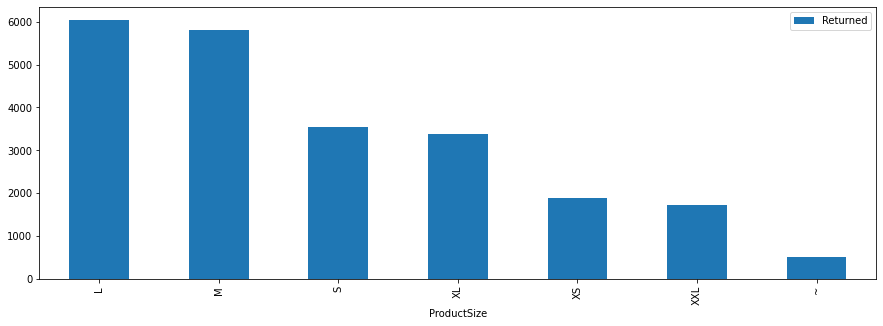

In [12]:
# lets look at returns by product size

df2 = train.groupby('ProductSize').sum().reset_index()
df2.plot(kind = 'bar', x = 'ProductSize', y = 'Returned')

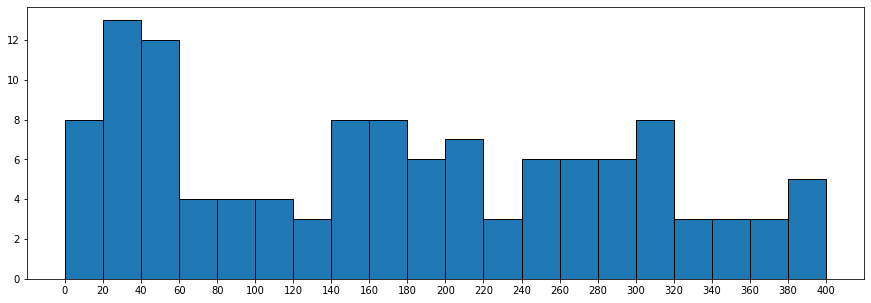

In [13]:
#Lets look at returns by price range

df3 = train
df3['PurchasePrice'] = df3['PurchasePrice'].astype('int')
df3 =df3.groupby('PurchasePrice').sum().reset_index()

bins= [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400]
plt.hist(df3['Returned'].values, bins=bins, edgecolor="k")
plt.xticks(bins)

plt.show()

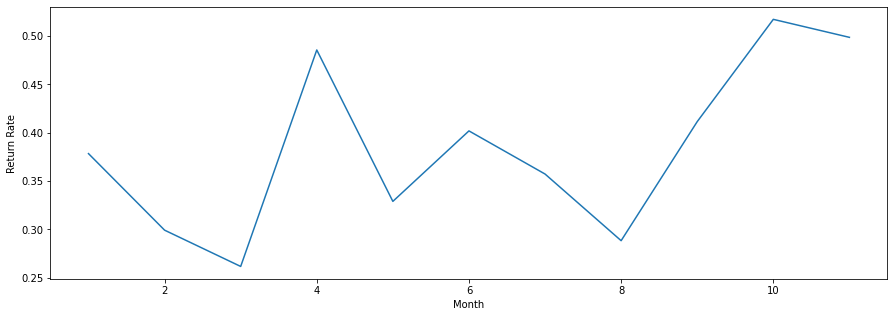

In [18]:
#Lets look at the rate of return by month

df4 = train
df4 = df4.groupby([df4['OrderDate'].dt.month]).agg (sum_returns_month = ('Returned' , 'sum'))
df4 = df4.reset_index()

df5 = train
df5 = df5['OrderDate'].groupby([df5['OrderDate'].dt.month]).agg('count')
df5 = df5.to_frame()

#Add column return rate
df5['ReturnRate'] = df4['sum_returns_month'] / df5['OrderDate']

#Plot graph
plt.plot(df4['OrderDate'], df5['ReturnRate'])
plt.xlabel('Month')
plt.ylabel('Return Rate')
plt.show()

It seems people return things more during October, November, December and April as well.

<AxesSubplot:xlabel='bin', ylabel='Returned'>

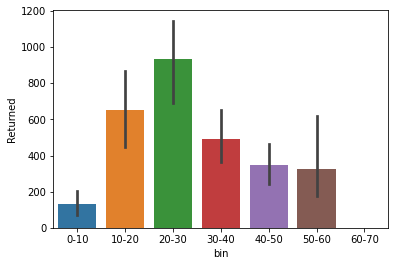

In [3]:
#Lets look at returns by product cost

productcost_counts = train.groupby('ProductCost').sum().reset_index()
productcost_counts['bin'] = pd.cut(productcost_counts['ProductCost'], bins=range(0,71,10), labels=[f'{l}-{l+10}' for l in range(0,61,10)])
sns.barplot(x='bin', y='Returned', data=productcost_counts)

<AxesSubplot:xlabel='bin', ylabel='Returned'>

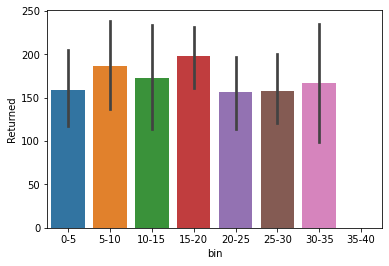

In [4]:
#Lets also look at discount percentages and returns

discountpct_counts = train.groupby('DiscountPct').sum().reset_index()
discountpct_counts['DiscountPct'] = discountpct_counts['DiscountPct'] *100
discountpct_counts['bin'] = pd.cut(discountpct_counts['DiscountPct'], bins=range(0,41,5), labels=[f'{l}-{l+5}' for l in range(0,36,5)])
sns.barplot(x='bin', y='Returned', data=discountpct_counts)

# Feature selection and engineering

We need to select the features that will be relevant for making our building an accurate model. Since the rate of return by state is almost equal for every state, it doesn't seem to be an important variable. However the month it was ordered and the product cost seem to be more telling of whether an item will be returned. Also if it is a mens or womens product that is Medium or Large, it has a higher chance of being returned, most likely because these are the most ordered items and people don't know their sizes when ordering online.

In [5]:
#Quick look at correlations

corrs = round(train.corr(), 2)
display(corrs['Returned'])

ProductCost      0.06
DiscountPct     -0.01
PurchasePrice    0.08
Returned         1.00
Name: Returned, dtype: float64

In [8]:
#Build the features

from sklearn.preprocessing import OneHotEncoder

dftest = pd.DataFrame()

dftest['Age'] = train['Age']
dftest['OrderMonth'] = train['OrderDate'].dt.month
dftest['ProductDepartment'] = train['ProductDepartment']
dftest['ProductSize'] = train['ProductSize']
dftest['ProductCost'] = train['ProductCost']
dftest['PurchasePrice'] = train['PurchasePrice']


#Turn the categorical variables into numerical variables for the ML algorithms
column = 'ProductSize'
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(dftest[['ProductSize']]).toarray()
items = [f'{column}_{item}' for item in encoder.categories_[0]]
dftest[items] = onehotarray

column = 'ProductDepartment'
onehotarray = encoder.fit_transform(dftest[['ProductDepartment']]).toarray()
items = [f'{column}_{item}' for item in encoder.categories_[0]]
dftest[items] = onehotarray

dftest.drop(['ProductDepartment', 'ProductSize'], axis=1, inplace=True)

dftest['Returned'] = train['Returned']

#Quick look at dataframe
dftest.head()

,Age,OrderMonth,ProductCost,PurchasePrice,ProductSize_L,ProductSize_M,ProductSize_S,ProductSize_XL,ProductSize_XS,ProductSize_XXL,ProductSize_~,ProductDepartment_Accessories,ProductDepartment_Mens,ProductDepartment_Womens,ProductDepartment_Youth,Returned
0,49,1,9,28.93,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,49,1,17,44.92,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,49,1,20,48.98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,49,1,17,51.37,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,37,1,42,113.91,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


# Evaluation

In [9]:
#Normalize and split data
from sklearn.model_selection import train_test_split

x = dftest[dftest.columns[:-1]].values
y = dftest['Returned'].values

#Leave 20% for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

#minmax scale
mins = X_train.min(axis =0)
maxs = X_train.max(axis=0)

X_train = (X_train - mins) / (maxs-mins)
X_test = (X_test - mins) / (maxs-mins)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(51929, 15) (12983, 15) (51929,) (12983,)


Run different models and score performance.

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1)
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6461526611723022

In [11]:
import xgboost as xgb

model = xgb.XGBClassifier(learning_rate = 0.1, colsample_bytree = 1, min_child_weight = 1, max_depth = 2, n_estimators = 100)
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6453824231687592

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 1)
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6365246861280136

# Predict for the actual test data

In [13]:
#Quick look at test data
test.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned
0,a6f6ecd9-2c08-4363-baf7-b54adc35d486,ad944d45-a857-4156-ac31-6d0eeb8a4bb7,49d38db8-e5f6-45a6-bbc1-6c6ed1f0214d,South Carolina,1976-10-21,2021-01-01,Accessories,~,19,0.2414,34.14,NaN
1,e819be63-7a98-4e6d-b217-03f9ac8c1d03,cefde178-45a0-406f-becf-31c003430d6f,65d3e42c-158f-4104-8dd2-cd8d1379ecf1,California,1961-10-31,2021-01-01,Mens,M,28,0.2771,73.74,NaN
2,8936a1c6-f5eb-4c78-9636-e693aae49d9f,24d7df06-80b2-416d-85e7-0ce8bd442b3f,5341a19e-27dd-42f9-8f8d-bbb76df99e71,Indiana,1953-11-03,2021-01-01,Womens,XXL,21,0.2665,35.21,NaN
3,68b74b1d-deab-4d93-bfe8-859d450952ef,24d7df06-80b2-416d-85e7-0ce8bd442b3f,5341a19e-27dd-42f9-8f8d-bbb76df99e71,Indiana,1953-11-03,2021-01-01,Womens,XXL,23,0.2305,70.79,NaN
4,657abc10-0b36-49df-b3ae-a1a6b9d1d145,086b01d2-8ab8-424d-8494-284cea56ae92,9efd2c6d-fa30-442a-a99a-d5bb2f284bf6,Oregon,1966-01-10,2021-01-01,Accessories,~,13,0.2621,30.99,NaN


In [14]:
#Build same features
dftest1 = pd.DataFrame()

#Add age as a column
test['OrderDate']= pd.to_datetime(test['OrderDate'])
test['CustomerBirthDate']= pd.to_datetime(test['CustomerBirthDate'])
test['Age'] = test['OrderDate'] - test['CustomerBirthDate']
test['Age'] = test['Age'] / np.timedelta64(1, 'Y')
test['Age'] = test['Age'].astype('int')

#Features build
dftest1['Age'] = test['Age']
dftest1['OrderMonth'] = test['OrderDate'].dt.month
dftest1['ProductDepartment'] = test['ProductDepartment']
dftest1['ProductSize'] = test['ProductSize']
dftest1['ProductCost'] = test['ProductCost']
dftest1['PurchasePrice'] = test['PurchasePrice']

#Convert categorical variables to numerical
column = 'ProductSize'
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(dftest1[['ProductSize']]).toarray()
items = [f'{column}_{item}' for item in encoder.categories_[0]]
dftest1[items] = onehotarray

column = 'ProductDepartment'
onehotarray = encoder.fit_transform(dftest1[['ProductDepartment']]).toarray()
items = [f'{column}_{item}' for item in encoder.categories_[0]]
dftest1[items] = onehotarray

dftest1.drop(['ProductDepartment', 'ProductSize'], axis=1, inplace=True)

#Check dataframe
dftest1.head()

,Age,OrderMonth,ProductCost,PurchasePrice,ProductSize_L,ProductSize_M,ProductSize_S,ProductSize_XL,ProductSize_XS,ProductSize_XXL,ProductSize_~,ProductDepartment_Accessories,ProductDepartment_Mens,ProductDepartment_Womens,ProductDepartment_Youth
0,44,1,19,34.14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,59,1,28,73.74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67,1,21,35.21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,67,1,23,70.79,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,54,1,13,30.99,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [15]:
#minmax scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(dftest1)

print(scaled.shape)

(14809, 15)


Logistic Regression scored the best for the training data so that is what I will use for the predictions.

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1)
model = model.fit(X_train, y_train)
preds = model.predict_proba(scaled)
display(preds)

array([[0.8921231 , 0.1078769 ],
       [0.64918472, 0.35081528],
       [0.6145154 , 0.3854846 ],
       ...,
       [0.61810984, 0.38189016],
       [0.60403306, 0.39596694],
       [0.61030325, 0.38969675]])

The array shows the predicted probability for the class of 0(not returned) and 1(returned). Either column will work but the second one is what we're looking for.

In [18]:
finalpreds = pd.DataFrame ()
finalpreds['ID'] = test['OrderID']
finalpreds['Prediction'] = preds[:,1]
finalpreds.head()

,ID,Prediction
0,ad944d45-a857-4156-ac31-6d0eeb8a4bb7,0.107877
1,cefde178-45a0-406f-becf-31c003430d6f,0.350815
2,24d7df06-80b2-416d-85e7-0ce8bd442b3f,0.385485
3,24d7df06-80b2-416d-85e7-0ce8bd442b3f,0.401255
4,086b01d2-8ab8-424d-8494-284cea56ae92,0.116301


In [19]:
finalpreds.to_csv("finalpreds.csv")